<h1>Hands On: Decision Trees.</h1>

En este notebook se estudia el uso de Decision Trees para la clasificación y regresión. Los algoritmos de Decision Tree son versátiles y potentes, capaces de predecir sobre datasets complejos. Además son el componente básico de los Random Forest, que están entre los algoritmos ML más potentes hoy en día. Los apartados a estudiar en este notebook son los siguientes:

  - Entrenamiento y visualización de un Decision tree
  - Pedicción y estimación de probabilidades de una clase.
  - Algoritmo CART y complejidad computacional.
  - ¿GINI o Entropía? 
  - Regularización de hiperparámetros.
  - Regresión.
  - Inestabilidad.
  
El objetivo es explicar la forma de predecir de un Decission tree, cómo se entrena y cçomo se visualiza. Además se estudiará el algoritmo CART (usado en Sklearn), y como regularizarlos y usarlos para regresión. Por último, la idea es conocer las limitaciones del algoritmo.

<h3>Imports</h3>

In [1]:
# Imports generales:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz
from graphviz import Source
import os

# Algoritmos:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

<h2>Entrenamiento y Visualización de un Decision Tree</h2>

Para entender cómo funcionan los árboles basta con entrenar uno y ver como predice:

In [2]:
iris = load_iris()

# Cogemos únicamente el largo y ancho del pétalo
X= iris.data[:,2:]
y= iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

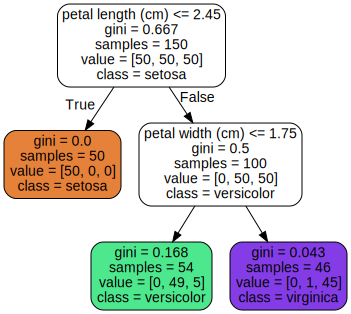

In [3]:
# Para visualizar el arbol hay que guardarlo en un archivo .dot (por ejemplo iris_tree.dot) y abrirlo usando 
# el paquete Graphviz (que es open source, y se debe instalar en terminal tambien, no solo la libreria de python)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))
# Para convertir el .dot a png se puede ejecutar el siguiente comando: dot -Tpng iris_tree.dot -o iris_tree.png

<h2>Predicción y estimación de probabilidades de una clase</h2>

La forma en la que un árbol (p.e el de arriba) hace predicciones es simple: suponiendo una nueva flor a clasificar, basta con ponerse en el primer nodo (el de más arriba) e ir bajando por las ramas que le corresponda en función de los criterios establecidos en las cajas blancas. Al final se obtiene una clasificación para la nueva flor.

El valor gini existente en cada nodo es el resultado de la Gini impurity del mismo. La Gini impurity es menor cuantas menos instances incorrectas se cataloguen en el nodo correspondiente durante el training set (si no hay ninguna instance errónea, la Gini impurity será 0). La ecuación que describe la Gini impurity es la siguiente:

    G_i = 1 - sum (p_(i,k)²)      , con i=1...n
    
Donde p_(i,k) es el ratio de instancias de la clase k en el nodo i.

Nota: Sklearn utiliza el algoritmo CART, que sólo produce árboles binarios (con respuestas si/no), y que estudiaremos después. Existen otros algoritmos como ID3 que permiten tener respuestas distintas a si/no, ergo más de dos hijos por rama.


Nota2: Los árboles de decisión son considerados white box models ya que son muy intuitivos de explicar y representar. Otros como los Random Forest o las redes neuronales son conocidos como black box models porque, a pesar de que suelen ser mucho mejores a la hora de predecir, no son tan simples si se quiere analizar la forma en la cual predicen.

En los decision tree, además de obtener una clase asignada, es posible obtener la probabilidad de una instancia de pertenecer a cada una de las clases sobre las que se clasifica. La idea es que primero se clasifica, y después se busca la distribución de las instancias de la clase asignada entre los distintos nodos (es decir, cómo se han distribuido las instances del training set de la misma clase entre los distintos nodos). Esto se hace tal que así:

In [4]:
new_instance = [5,1.5]
print ('El predict_proba da: ' + str(tree_clf.predict_proba([new_instance])))
print ('Y el predict dice que pertenece a la clase ' + str(tree_clf.predict([new_instance])))

El predict_proba da: [[0.         0.90740741 0.09259259]]
Y el predict dice que pertenece a la clase [1]


<h2>Algoritmo CART y complejidad computacional</h2>

Sklearn usa el algoritmo Classification And Regression Tree (CART) para entrenar Decision Trees ("growing" trees). La idea es muy simple: primero se separa el training set en dos subsets usando una sola feature k y un threshold t_k (p.e. largo del pétalo <= 2.45). Cómo se seleccionan la variable y el valor del threshold? Encontrando el par variable-valor que minimiza la siguiente función coste:

    J(k,t_k) = m_left/m * G_left + m_right/m * G_right
    
Donde G mide la Gini Impurity del set derecha/izquierda y m es el número de instances del set correspondiente.

Una vez se ha separado el training set en dos, se vuelve a separar utilizando la misma lógica. Se acaba de separar el dataset una vez se haya alcanzado la profundidad indicada (mediante el hiperparámetro max_depth) o ya no se pueda encontrar un split que reduzca la impureza.

Existen algunos otros parámetros para controlar la finalización de estas separaciones (p.e. min_samples_split, min_samples_leaf,...). 

Nota: El algoritmo CART es un algoritmo greedy: busca de forma greedy una solución óptima al split en cada nivel antes de pasar al siguiente. Por esto es posible que no encuentre la solución óptima: esto es un problema NP-Complete, requiere de O(exp(m)) tiempo de computación para hacer la solución perfecta, por lo que hay que conformarse con una solución "buena".

Nota de la Nota: Un problema P es aquel que puede resolverse en polynomial time. NP es el problema que puede verificar su solución en un tiempo polinómico. Un NP-Hard es aquel problema que permite reducir un NP problem en tiempo polinómico. Un problema NP-Complete es a la vez NP y NP-Hard.

Hacer predicciones en un árbol de decisión es bastante rápido, independientemente del número de variables, ya que en cada nodo solo se comprueba una de estas variables. Esto da una complejidad computacional de O(log_2(m)) donde m es el número de predicciones a hacer.

Sin embargo entrenarlo es más costoso, ya que se comparan todas las variables (si max_features esta activo) de todas las submuetsras en cada nodo. Esto hace que la complejidad computacional sea O(n*m*log(m)). Para training sets pequeños, Sklearn acelera un poco el asunto preordenando los datos, pero esto lo ralentiza para datasets grandes.

<h2>GINI o Entropía</h2>

Por defecto se usa la Gini impurity, pero se puede seleccionar la entropía como medida a la hora de hacer un árbol de decisión (en Sklearn se usa el hiperparámetro criterion='entropy'). La entropía es una medida del desorden (p.e. desorden molecular en termodinámica, mensajes distintos en un set de mensajes o clases distintas en un set de datos a clasificar). La ecuación que definde la entropía es la siguiente:

    H_i = - sum(p_i * log_2(p_(i,k)))                 con k=1...n      y          p_(i,k) <> 0
    
En general da bastante igual cual usar. Gini es más rápida de computar, pero la entropía tiende a crear árboles más balanceados (Gini aisla aquellas clases mas frecuentes en sus propias ramas).

<h2>Hiperparámetros de regularización</h2>

Los árboles de decisión no hacen asumpciones sobre los dataset. Si no se ponen constraints, el árbol se adaptará perfectamente al dato, tendiendo a hacer overfitting. Estos modelos se suelen llamar no-paramétricos, no porque no necesiten parámetros, si no porque el número de los mismos no está determinado antes del entrenamiento.

Para evitar el overfitting se debe restringir la libertad del modelo a la hora de ajustar el dato. Los hiperparámetros de regularización dependen del algoritmo utilizado, pero en general se puede restringir la profundidad del árbol de decisión (usando max_depth en Sklearn). Existen otros hiperparámetros que restringen de forma similar (fracciones de dataset minimas por subset, minimo de instancias en un subset, etc).

Nota: Otros algoritmos entrenan el Decission tree sin restricciones y después podan (prunning) los nodos innecesarios. Estos podados se suelen hacer midiendo la importancia estadística, por medio de chi² tests (hipótesis nula) midiendo el p-valor, viendo si es mayor a 0.05 y borrando los que no.

<h2>Regresión</h2>

También se pueden usar árboles para hacer regresión. Por ejemplo:

In [5]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

La idea es similar a la de clasificar, pero en lugar de predecir una clase se predice un valor posible. El valor predicho es, simplemente, el promedio de todos los valores que caigan en el subconjunto.


Para tener una idea más visual de lo que está pasando, vamos a comparar un entrenamiento poniendo el max_depth en 2 y luego en 3:

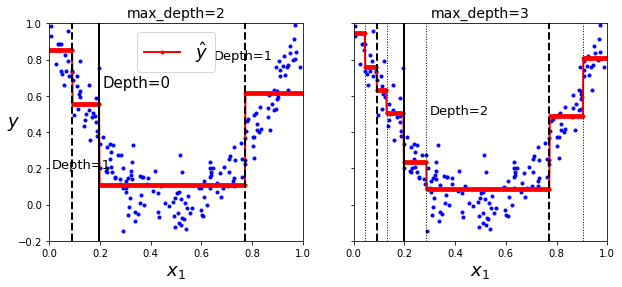

In [7]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

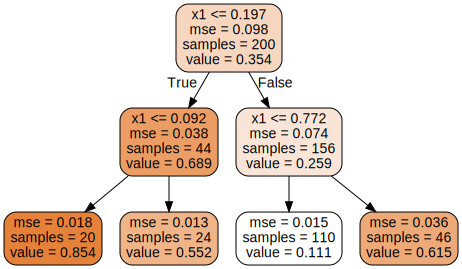

In [8]:
# Vamos a verlo gráficamente:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

El algoritmo CART funciona exactamente igual que antes, excepto que primero intenta minimiar la impureza y después intenta minimizar el MSE. La función coste sería la siguiente: 

    J(k,t_k) = m_left/m * MSE_left + m_right/m * MSE_right            donde MSE_nodo = sum(y^_nodo - y^(i))² 
    
                                                                            y^nodo = 1/m_nodo * sum(y^(i))
                                                                            
Igual que los árboles de decisión, los de regresión también tienden al overfitting. Visualmente, sin usar ninguna regularización (izq) se puede ver como overfittea, y regularizando ya queda bastante mejor:

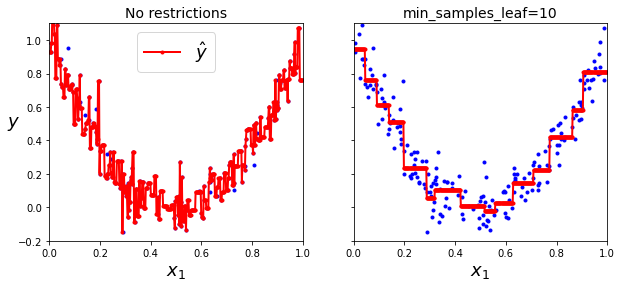

In [9]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

<h2>Inestabilidad</h2>

El principal problema de los Decision Trees es que utilizan decision boundaries ortogonales. Por eso son muy susceptibles a la rotación del training set. Esto provoca que a veces no generalicen bien, pero se soluciona usando un Principal Component Analysis (PCA).

Además son susceptibles a variaciones pequeños en los datos, y el entrenamiento en Sklearn es estocástico, por lo que si no se selecciona un random_state cada vez se obtiene un árbol distinto.

Estos problemas de inestabilidad se solucionan con Random Forest.